In [ ]:

from tqdm import tqdm,tnrange
# from pulp import *
from scipy.linalg import expm
# from ortools.linear_solver import pywraplp
# from ortools.sat.python import cp_model

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import elitism

import os , time , copy
import pickle , json

# set the random seed:
RANDOM_SEED = 10
random.seed(RANDOM_SEED)

Criteria = "MC"
num_catchments = 7
num_years = 7
Ucost = 1.38
a = 0.1
budgetb = 10000
#budget = [budgetb for i in range(num_years)] #Budget Profile
#budget = [45000,50000,55000,60000,65000,70000,75000] #Budget Profile
Tol=0.15

dfCL = pd.read_pickle(r'/content/drive/MyDrive/Data/dfCL').round(2)
dfT = pd.read_pickle(r'/content/drive/MyDrive/Data/dfT').round(2)

dfT.rename(columns={'SHAPE_Length': 'Len'}, inplace=True)

dfCL = dfCL.iloc[0:num_catchments]
catchments = dfCL.index

dfCL = pd.DataFrame(dfCL)
dfCL.columns = ['Len']

dfT["Tran"] = ""
dfT["Init"] = ""
dfT["Tran"] = dfT["Tran"].astype(object)
dfT["Init"] = dfT["Tran"].astype(object)
dfT["Next"] = ""
dfT["Mean"] = ""
dfT["Next"] = dfT["Next"].astype(object)

dfCL["Tran"] = ""
dfCL["Init"] = ""
dfCL["Next"] = ""
dfCL["Mean"] = ""
dfCL["MeanLen"] = ""
dfCL["PPA"] = ""
dfCL["PPALen"] = ""
dfCL["TPR"] = ""
dfCL["Tran"] = dfCL["Tran"].astype(object)
dfCL["Init"] = dfCL["Init"].astype(object)
dfCL["Next"] = dfCL["Next"].astype(object)
dfCL["TPR"] = dfCL["TPR"].astype(object)


for i in range(len(dfT)):
    a = 1-dfT.Degradation_Rate[i]
    lambda1 = dfT.lambda1[i]
    lambda2 = dfT.lambda2[i]
    lambda3 = dfT.lambda3[i]
    lambda4 = dfT.lambda4[i]
    Q = np.array([[-lambda1, lambda1, 0, 0, 0],
                  [0, -lambda2, lambda2, 0, 0],
                  [0, 0, -lambda3, lambda3, 0],
                  [0, 0, 0, -lambda4, lambda4],
                  [0, 0, 0, 0, 0]])
    Q = Q * 1                ######################################  Degradation Rate Factor #####################
    dfT.Tran[i] = np.around(expm(Q), decimals=3)
    print(np.around(Q, decimals=3))
    print(dfT.Tran[i])
    if np.isnan(np.sum(dfT.Tran[i])):
        dfT.Tran[i]=np.array([[0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1]])


    
    dfT.Init[i]=np.array([0, 0, 0, 0, 0])
    if dfT.Current[i]==0:
        dfT.Init[i][0]=1
    else:
        dfT.Init[i][dfT.Current[i]-1]=1


        
for catchment in catchments:
    dfC = dfT.loc[dfT['Catchment_Group'] == catchment].copy()
    dfC['TranLen']=dfC.Tran*dfC.Len
    STranLen = sum(dfC['TranLen'])
    net_tran = STranLen/np.sum(STranLen,1)
    dfCL.Tran[catchment] = net_tran
   
    dfC['InitLen']=dfC.Init*dfC.Len
    SInitLen=sum(dfC['InitLen'])
    net_init = SInitLen/np.sum(SInitLen)
    dfCL.Init[catchment] = net_init







dfCL_org = dfCL.copy()

S = np.array([1,2,3,4,5])

dfCL = dfCL_org.copy()



# Flushing Transition Matrix
FlushTran = np.array([[1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0]])

def getCatchmentPlan(plan):
    """
    Converts the entire network plan into a dictionary with a separate plan for each catchment
    :param schedule: a list of binary values describing the given schedule
    :return: a dictionary with each catchment as a key and the corresponding plan as the value
    """
    
    catchmentplanDict = {}
    shiftIndex = 0

    for catchment in catchments:
        catchmentplanDict[catchment] = plan[shiftIndex:shiftIndex + num_years]
        shiftIndex += num_years

    return catchmentplanDict

def condition(CatchmentPlan,catchment):
    """
    Calculate the states of each catchment throughout the period according to the plan
    :param CatchmentPlan: a list of binary values describing the catchment plan
    :return: a list of numpy arrays presenting the states in each year
    """
    
    state_list = []
    state = dfCL.Init[catchment]
    for i in range(len(CatchmentPlan)):
        new_state = (1-CatchmentPlan[i])*np.dot(state,dfCL.Tran[catchment])+ CatchmentPlan[i]*np.dot(state,FlushTran)
        state_list.append(new_state)
        state = new_state.copy()
    return state_list

def nextcond():
    dfCL.Next = dfCL.apply(lambda x: np.dot(x.Init, x.Tran), axis=1)
    dfCL.Mean = dfCL.apply(lambda x: (np.dot(S, x.Next.T)), axis=1)
    dfCL.MeanLen = dfCL.Mean*dfCL.Len
    dfCL.PPA = dfCL.apply(lambda x: x.Next[0,3]+x.Next[0,4], axis=1)
    dfCL.PPALen = dfCL.PPA*dfCL.Len
    


def getObjCatchment(CatchmentStates):
    MeanC_Catchment = []
    PPA_Catchment = []
    for i in range(len(CatchmentStates)):
        MeanC_Catchment.append(np.dot(S,CatchmentStates[i].T))
        PPA_Catchment.append(CatchmentStates[i][3]+CatchmentStates[i][4])

    return sum(MeanC_Catchment)/num_years , sum(PPA_Catchment)/num_years , MeanC_Catchment , PPA_Catchment


def getObjCatchment2(CatchmentPlan,catchment):
    dfC = dfT.loc[dfT['Catchment_Group'] == catchment].copy()
    condition_list=[]
    for i in range(len(CatchmentPlan)):
        if CatchmentPlan[i]==1:
            dfC.Next = dfC.apply(lambda x: np.dot(x.Init, FlushTran), axis=1)
        else:
            dfC.Next = dfC.apply(lambda x: np.dot(x.Init, x.Tran), axis=1)
        dfC.Mean = dfC.apply(lambda x: sum(sum((np.dot(S, x.Next.T)))), axis=1)
        obj = sum(dfC.Len*dfC.Mean)/sum(dfC.Len)
        condition_list.append(obj)
        dfC.Init = dfC.Next.copy()
    return sum(condition_list)/len(condition_list)


def BudgetConstraint(catchmentplanDict):
    num_hard_violation = 0
    percent = 0
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        if cost > budgetb*(1+Tol):
            num_hard_violation +=1
            percent += abs(cost-budgetb*(1+Tol))/(budgetb*(1+Tol))
        if cost < budgetb*(1-Tol):
            num_hard_violation +=1
            percent += abs(cost-budgetb*(1-Tol))/(budgetb*(1-Tol))
    
    return num_hard_violation, percent

def BudgetConstraintTotal(catchmentplanDict):
    num_budget_violation = 0
    total_budget_percent = 0
    costT = 0
    budgetTotal = budgetb*num_years
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        costT += cost
    if costT > budgetTotal:
        num_budget_violation +=1
        total_budget_percent += (costT-budgetTotal)/budgetTotal

    
    return num_budget_violation, total_budget_percent

def OneFlushConstraint(catchmentplanDict):
    num_soft_violation = 0
    soft = 0
    for C in catchments:
        if sum(catchmentplanDict[C]) == 0:
            num_soft_violation +=1
            soft += dfCL.Len[C]
    soft_percent = soft/dfCL.Len.sum()       
    return num_soft_violation, soft_percent  



def getObj(plan):
    """
    Calculates the total cost of the various violations in the given network plan
    ...
    :param plan: a list of binary values describing the given network plan
    :return: the calculated cost
    """
    # convert entire schedule into a dictionary with a separate schedule for each catchment:
    catchmentplanDict = getCatchmentPlan(plan)
    MeanC_Catchment_List = []
    PPA_Catchment_List = []
    for C in catchments:
        CatchmentStates = condition(catchmentplanDict[C],C)
        MeanC_Catchment , PPA_Catchment , _ , _  = getObjCatchment(CatchmentStates)
        MeanC_Catchment_List.append(MeanC_Catchment) 
        PPA_Catchment_List.append(PPA_Catchment)
    #print(Obj_Catchment_List)
    if Criteria == "PPA":
        Obj_Network = (sum(np.array(dfCL.Len)*np.array(PPA_Catchment_List)))/sum(dfCL.Len)
    else:
        Obj_Network = (sum(np.array(dfCL.Len)*np.array(MeanC_Catchment_List)))/sum(dfCL.Len)
    
    
    #add penalty for violating constraint
    num_hard_violation , percent_hard_violation = BudgetConstraint(catchmentplanDict)
    num_soft_violation , percent_soft_violation = OneFlushConstraint(catchmentplanDict)
    num_budget_violation, total_budget_percent = BudgetConstraintTotal(catchmentplanDict)
    
    #Obj_Network_WC = Obj_Network+num_hard_violation*HARD_CONSTRAINT_PENALTY+num_soft_violation*SOFT_CONSTRAINT_PENALTY
    Obj_Network_WC = Obj_Network+percent_hard_violation*HARD_CONSTRAINT_PENALTY+percent_soft_violation*SOFT_CONSTRAINT_PENALTY+BUDGET_TOTAL_PENALTY*total_budget_percent
    return Obj_Network_WC , Obj_Network

def getPerformance(plan):
    """
    Calculates the total cost of the various violations in the given network plan
    ...
    :param plan: a list of binary values describing the given network plan
    :return: the calculated cost
    """
    # convert entire schedule into a dictionary with a separate schedule for each catchment:
    
    performance = pd.DataFrame(columns = [i for i in range(1,num_years+1)], index = catchments)
    
    catchmentplanDict = getCatchmentPlan(plan)
    for C in catchments:
        CatchmentStates = condition(catchmentplanDict[C],C)
        _, _, MeanC_Catchment , PPA_Catchment = getObjCatchment(CatchmentStates)
        if Criteria == "PPA":
            performance.loc[C] = [i*dfCL.Len[C]/dfCL.Len.sum() for i in PPA_Catchment]
        else:
            performance.loc[C] = [i*dfCL.Len[C]/dfCL.Len.sum() for i in MeanC_Catchment]
    return performance.sum().tolist()    


def printPlanInfo(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)

    print("Plan for each Catchment:")
    for catchment in catchmentplanDict: 
        print(catchment, ":", catchmentplanDict[catchment])
    print()
    print("Yearly Budget violations = ", BudgetConstraint(catchmentplanDict))
    print()
    print("Total Budget violations = ", BudgetConstraintTotal(catchmentplanDict))
    print()
    print("Minimum flush violations = ", OneFlushConstraint(catchmentplanDict))
    print()
    
    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
    print("Required budget for this plan: ", [round(num, 1) for num in required_budget] )
    print()
    print("Total required budget: ", round(sum(required_budget), 1))
    print()
    Obj_Network_WC , Obj_Network = getObj(plan)
    print("Network objective without penalty: ", Obj_Network )
    print()
    print(pd.DataFrame(np.array(plan).reshape(num_catchments,num_years),index=catchments, columns=range(1,1+num_years)))
    



def Optimizeplan():  
    plan = pd.DataFrame(index = catchments)
    for year in range(1,num_years):
        plan[str(year)]=''
        nextcond()
        model = LpProblem(name="Flushing-Plan", sense=LpMinimize)
        x = {i: LpVariable(name="{0}".format(dfCL.index[i]), lowBound=0, upBound=1, cat=LpInteger ) for i in range(len(catchments))}
        if Criteria == "PPA":        
            model += sum(dfCL.PPALen)-lpDot(dfCL.PPALen.tolist(), x.values())
        else:
            model += sum(dfCL.MeanLen)-lpDot(dfCL.MeanLen.tolist(), x.values())+lpDot(dfCL.Len.tolist(), x.values())
            
        model += (lpDot(dfCL.Len.tolist(), x.values())*Ucost <= budget[year-1] , "Budget Constraint")
        status = model.solve()
        for var in x.values():
            #print(f"{var.name}: {var.value()}")
            if var.value()==1:
                plan[str(year)][var.name]=1
            else:
                plan[str(year)][var.name]=0

        for c in catchments:
            if plan[str(year)][c]==1:
                dfCL['Init'][c] = np.dot(dfCL['Next'][c], FlushTran)
            else:
                dfCL['Init'][c] = dfCL['Next'][c]

    year = num_years
    noflush = []
    noflushcost = []
    for c in catchments:
        if plan.loc[c,:].sum() == 0:
            noflush.append(c)
            noflushcost.append(dfCL.Len[c]*Ucost) 
    if sum(noflushcost) > budget[year-1]:
        print()
        print()
        print('The budget is not enough for the remaining catchments')
        print()
        print()

    plan[str(year)]=''
    nextcond()
    model = LpProblem(name="Flushing-Plan", sense=LpMinimize)
    x = {i: LpVariable(name="{0}".format(dfCL.index[i]), lowBound=0, upBound=1, cat=LpInteger ) for i in range(len(catchments))}
    if Criteria == "PPA":        
        model += sum(dfCL.PPALen)-lpDot(dfCL.PPALen.tolist(), x.values())
    else:
        model += sum(dfCL.MeanLen)-lpDot(dfCL.MeanLen.tolist(), x.values())+lpDot(dfCL.Len.tolist(), x.values())
    model += (lpDot(dfCL.Len.tolist(), x.values())*Ucost <= budget[year-1] , "Budget Constraint")
    for c in noflush:
        catchmentlist = catchments.values.tolist()
        model += (x[catchmentlist.index(c)] == 1)
    status = model.solve()
    for var in x.values():
        #print(f"{var.name}: {var.value()}")
        if var.value()==1:
            plan[str(year)][var.name]=1
        else:
            plan[str(year)][var.name]=0
    
    return planlist(plan)

def planlist(plan):
    sol = []
    for c in catchments:
        for year in range(1,num_years+1):
            sol.append(plan[str(year)][c])
    return sol




Tplan = []
for i in range(2**num_years):
    strplan = (format(i, '0'+str(num_years)+'b'))
    plan = [int(j) for j in strplan]
    Tplan.append(plan)
    


for C in tqdm(catchments):
    TPR = []
    for p in Tplan:
        dfCL = dfCL_org.copy()
        CatchmentStates = condition(p,C)
        MeanC_Catchment , _ , _ , _  = getObjCatchment(CatchmentStates)
        TPR.append(MeanC_Catchment)
    dfCL_org.TPR[C] = np.array(TPR)

    
Cost = {}
for x in range(1, num_years+1):
    y = []
    for p in Tplan:
        y.append(p[x-1])
    Cost["{0}".format(x)] = y
    
    
def PlanInfo(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)
    
    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
        
    _ , Obj_Network = getObj(plan)
    return Obj_Network , round(sum(required_budget), 3)

<ipython-input-1-ab201db964de>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfT.Tran[i] = np.around(expm(Q), decimals=3)
<ipython-input-1-ab201db964de>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfT.Init[i]=np.array([0, 0, 0, 0, 0])


Streaming output truncated to the last 5000 lines.
[[-3.7   3.7   0.    0.    0.  ]
 [ 0.   -2.83  2.83  0.    0.  ]
 [ 0.    0.   -3.11  3.11  0.  ]
 [ 0.    0.    0.   -3.15  3.15]
 [ 0.    0.    0.    0.    0.  ]]
[[0.025 0.146 0.214 0.224 0.391]
 [0.    0.059 0.146 0.213 0.582]
 [0.    0.    0.045 0.136 0.819]
 [0.    0.    0.    0.043 0.957]
 [0.    0.    0.    0.    1.   ]]
[[-4.4   4.4   0.    0.    0.  ]
 [ 0.   -3.11  3.11  0.    0.  ]
 [ 0.    0.   -3.54  3.54  0.  ]
 [ 0.    0.    0.   -4.81  4.81]
 [ 0.    0.    0.    0.    0.  ]]
[[0.012 0.11  0.178 0.16  0.539]
 [0.    0.045 0.113 0.128 0.714]
 [0.    0.    0.029 0.058 0.913]
 [0.    0.    0.    0.008 0.992]
 [0.    0.    0.    0.    1.   ]]
[[-4.47  4.47  0.    0.    0.  ]
 [ 0.   -3.14  3.14  0.    0.  ]
 [ 0.    0.   -3.58  3.58  0.  ]
 [ 0.    0.    0.   -5.    5.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[0.011 0.107 0.175 0.154 0.553]
 [0.    0.043 0.11  0.122 0.725]
 [0.    0.    0.028 0.053 0.919]
 [0.    0.    0.    

<ipython-input-1-ab201db964de>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCL.Tran[catchment] = net_tran
<ipython-input-1-ab201db964de>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCL.Init[catchment] = net_init


[[-3.88  3.88  0.    0.    0.  ]
 [ 0.   -2.91  2.91  0.    0.  ]
 [ 0.    0.   -3.22  3.22  0.  ]
 [ 0.    0.    0.   -3.54  3.54]
 [ 0.    0.    0.    0.    0.  ]]
[[0.021 0.135 0.205 0.207 0.432]
 [0.    0.054 0.136 0.188 0.621]
 [0.    0.    0.04  0.11  0.85 ]
 [0.    0.    0.    0.029 0.971]
 [0.    0.    0.    0.    1.   ]]
[[-2.18  2.18  0.    0.    0.  ]
 [ 0.   -2.11  2.11  0.    0.  ]
 [ 0.    0.   -2.08  2.08  0.  ]
 [ 0.    0.    0.   -0.86  0.86]
 [ 0.    0.    0.    0.    0.  ]]
[[0.113 0.255 0.275 0.27  0.086]
 [0.    0.121 0.26  0.426 0.193]
 [0.    0.    0.125 0.508 0.367]
 [0.    0.    0.    0.423 0.577]
 [0.    0.    0.    0.    1.   ]]
[[-3.7   3.7   0.    0.    0.  ]
 [ 0.   -2.83  2.83  0.    0.  ]
 [ 0.    0.   -3.1   3.1   0.  ]
 [ 0.    0.    0.   -3.15  3.15]
 [ 0.    0.    0.    0.    0.  ]]
[[0.025 0.146 0.215 0.224 0.391]
 [0.    0.059 0.146 0.213 0.581]
 [0.    0.    0.045 0.136 0.819]
 [0.    0.    0.    0.043 0.957]
 [0.    0.    0.    0.    1.   ]]
[[-3

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-1-ab201db964de>:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCL_org.TPR[C] = np.array(TPR)
100%|██████████| 7/7 [00:00<00:00, 20.87it/s]


In [ ]:

# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 100
HARD_CONSTRAINT_PENALTY = 30
BUDGET_TOTAL_PENALTY = 30
SOFT_CONSTRAINT_PENALTY = 100



In [ ]:
import itertools
alist = []
falist = []
fcilist = []
costlist = []
fcostlist = []
ccost = np.asarray(dfCL.Len)*Ucost
# Define problem state (list of nonnegative integers)
action_space = [1,1,1,1,1,1,1]

# Create list of sets based on state
list_of_sets=[(j for j in range(action_space[i]+1)) for i in range(len(action_space))]

# Compute Cartesian product
num_actions=0
for action in itertools.product(*list_of_sets):
    print(action)
    num_actions +=1
    alist.append(action)
    action_cost = sum(ccost*np.asarray(action))
    costlist.append(action_cost)
    if (action_cost <= budgetb*(1+Tol) and action_cost >= budgetb*(1-Tol)):
        fci = 1
        falist.append(action)
        fcostlist.append(round(action_cost,1))
    else:
        fci = 0
    fcilist.append(fci)
    
    
print('Number of actions generated:', num_actions)
print('Number of feasible actions:', sum(fcilist))

adf = pd.DataFrame({'action':falist,'cost':fcostlist})

Tadf = pd.DataFrame({'action':alist,'cost':costlist})


(0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 1, 1)
(0, 0, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 1, 0, 1)
(0, 0, 0, 0, 1, 1, 0)
(0, 0, 0, 0, 1, 1, 1)
(0, 0, 0, 1, 0, 0, 0)
(0, 0, 0, 1, 0, 0, 1)
(0, 0, 0, 1, 0, 1, 0)
(0, 0, 0, 1, 0, 1, 1)
(0, 0, 0, 1, 1, 0, 0)
(0, 0, 0, 1, 1, 0, 1)
(0, 0, 0, 1, 1, 1, 0)
(0, 0, 0, 1, 1, 1, 1)
(0, 0, 1, 0, 0, 0, 0)
(0, 0, 1, 0, 0, 0, 1)
(0, 0, 1, 0, 0, 1, 0)
(0, 0, 1, 0, 0, 1, 1)
(0, 0, 1, 0, 1, 0, 0)
(0, 0, 1, 0, 1, 0, 1)
(0, 0, 1, 0, 1, 1, 0)
(0, 0, 1, 0, 1, 1, 1)
(0, 0, 1, 1, 0, 0, 0)
(0, 0, 1, 1, 0, 0, 1)
(0, 0, 1, 1, 0, 1, 0)
(0, 0, 1, 1, 0, 1, 1)
(0, 0, 1, 1, 1, 0, 0)
(0, 0, 1, 1, 1, 0, 1)
(0, 0, 1, 1, 1, 1, 0)
(0, 0, 1, 1, 1, 1, 1)
(0, 1, 0, 0, 0, 0, 0)
(0, 1, 0, 0, 0, 0, 1)
(0, 1, 0, 0, 0, 1, 0)
(0, 1, 0, 0, 0, 1, 1)
(0, 1, 0, 0, 1, 0, 0)
(0, 1, 0, 0, 1, 0, 1)
(0, 1, 0, 0, 1, 1, 0)
(0, 1, 0, 0, 1, 1, 1)
(0, 1, 0, 1, 0, 0, 0)
(0, 1, 0, 1, 0, 0, 1)
(0, 1, 0, 1, 0, 1, 0)
(0, 1, 0, 1, 0, 1, 1)
(0, 1, 0, 1, 1, 0, 0)
(0, 1, 0, 

In [ ]:
xxx = Tadf[(Tadf.cost >= budgetb*(1-Tol)) & (Tadf.cost <= budgetb*(1+Tol)) & (Tadf.cost <= budgetb*(1+Tol))] 

In [ ]:
random.choice(range(4))

3

In [ ]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict
import random

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Tadf

,action,cost
0,"(0, 0, 0, 0, 0, 0, 0)",0.0000
1,"(0, 0, 0, 0, 0, 0, 1)",1582.6116
2,"(0, 0, 0, 0, 0, 1, 0)",1947.2214
3,"(0, 0, 0, 0, 0, 1, 1)",3529.8330
4,"(0, 0, 0, 0, 1, 0, 0)",10155.6684
...,...,...
123,"(1, 1, 1, 1, 0, 1, 1)",20983.1070
124,"(1, 1, 1, 1, 1, 0, 0)",27608.9424
125,"(1, 1, 1, 1, 1, 0, 1)",29191.5540
126,"(1, 1, 1, 1, 1, 1, 0)",29556.1638


In [ ]:
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

num_years = 28
Total_budget = num_years*budgetb
BPF = 50  #budget penalty factor

actiondf = Tadf                                           ################### Action List ##############################################################

class SewerEnv(Env):
    def __init__(self):
        # Actions for 7 catchments
        self.action_space = Discrete(len(actiondf))
        self.time = 0
        self.components = num_catchments
        self.observation_space = Box(low=0.0, high=1.0, shape=(num_catchments+3, ), dtype=np.float32)
        self.state = self.reset()

    
    def reset(self):
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB

        return self.state
    
    
    

    def step(self, action, render=False):
                
        # Return step information
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True

        pcost = actiondf.loc[action].values[1]
        self.RB -= pcost/Total_budget 
        action = actiondf.loc[action].values[0]
        # transition possibility matrices
            
        # deterioration
        for component in range(self.components):  # for each component
            self.cond[component] = np.matmul(self.cond[component],trans[component, action[component]])
 
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        
        # calculate reward
        reward = 1 - self.state[num_catchments]
        
        # if done:
  
        if (self.RB < (1-self.state[8])*(1-Tol)):
          # done = True
          reward -= num_years/14
  
        if pcost > budgetb*(1+Tol):
          reward -= 1
          # reward -= BPF*(pcost-budgetb*(1+Tol))/(budgetb)
          # done = True
        if pcost < budgetb*(1-Tol):
          reward -= 1
          # reward -= BPF*(budgetb*(1-Tol)-pcost)/(budgetb)        
          # done = True
        
        info = {}
        
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    

    

In [ ]:
env = SewerEnv()

In [ ]:
env.reset()

array([0.06549152, 0.02285947, 0.07501461, 0.07223702, 0.        ,
       0.03599195, 0.09490944, 0.04491568, 0.        , 1.        ],
      dtype=float32)

In [ ]:
obs = env.reset()

In [ ]:
np.expand_dims(obs, 0)

array([[0.06549152, 0.02285947, 0.07501461, 0.07223702, 0.        ,
        0.03599195, 0.09490944, 0.04491568, 0.        , 1.        ]],
      dtype=float32)

In [ ]:
torch.FloatTensor(np.expand_dims(obs, 0))[0][num_catchments+2].numpy().item()

NameError: ignored

In [ ]:
env = SewerEnv()
env = env.unwrapped
action_dim = env.action_space.n

In [ ]:
env.action_space.n

128

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import gym

class prioritized_replay_buffer(object):
    def __init__(self, capacity, alpha, beta, beta_increment):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.pos = 0
        self.memory = []
        self.priorities = np.zeros([self.capacity], dtype=np.float32)

    def store(self, observation, action, reward, next_observation, done):
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)

        max_prior = np.max(self.priorities) if self.memory else 1.0

        if len(self.memory) < self.capacity:
            self.memory.append([observation, action, reward, next_observation, done])
        else:
            self.memory[self.pos] = [observation, action, reward, next_observation, done]
        self.priorities[self.pos] = max_prior
        self.pos += 1
        self.pos = self.pos % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < self.capacity:
            probs = self.priorities[: len(self.memory)]
        else:
            probs = self.priorities
        probs = probs ** self.alpha
        probs = probs / np.sum(probs)

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[idx] for idx in indices]

        weights = (len(self.memory) * probs[indices]) ** (- self.beta)
        if self.beta < 1:
            self.beta += self.beta_increment
        weights = weights / np.max(weights)
        weights = np.array(weights, dtype=np.float32)

        observation, action, reward, next_observation, done = zip(* samples)
        return np.concatenate(observation, 0), action, reward, np.concatenate(next_observation, 0), done, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)


class dqn(nn.Module):
    def __init__(self, observation_dim, action_dim):
        super(dqn, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(self.observation_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.action_dim)

    def forward(self, observation):
        x = self.fc1(observation)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def get_action(self, observation, epsilon):
        if random.random() > epsilon:
            q_value = self.forward(observation)
            action = q_value.max(1)[1].data[0].item()
        else:
            rtime = observation[0][num_catchments+1].numpy().item()
            rbudget = observation[0][num_catchments+2].numpy().item()
            tbudget = (rbudget-(1-(rtime+1/num_years))*(1-Tol))*Total_budget
            factions = Tadf[(Tadf.cost >= budgetb*(1-Tol)) & (Tadf.cost <= budgetb*(1+Tol)) & (Tadf.cost <= tbudget)]
            if len(factions) != 0:
              action = random.choice(factions.index)
            else:
              q_value = self.forward(observation)
              action = q_value.max(1)[1].data[0].item()
        return action


def training(buffer, batch_size, model, optimizer, gamma, loss_fn):
    observation, action, reward, next_observation, done, indices, weights= buffer.sample(batch_size)

    observation = torch.FloatTensor(observation)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    next_observation = torch.FloatTensor(next_observation)
    done = torch.FloatTensor(done)
    weights = torch.FloatTensor(weights)

    q_values = model.forward(observation)
    next_q_values = model.forward(next_observation)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0].detach()
    expected_q_value = reward + next_q_value * (1 - done) * gamma

    loss = (expected_q_value - q_value).pow(2) * weights
    priorities = loss + 1e-5
    buffer.update_priorities(indices, priorities)
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()





In [ ]:
training_reward_list = []
from collections import deque
scores_window = deque(maxlen=100)  # last 100 scores
if __name__ == '__main__':
    t0 = time.time()
    epsilon_init = 1.0
    epsilon_min = 0.001
    episode = 5000*4
    decay = 0.9995
    capacity = int(num_years*episode/5)
    exploration = int(episode/100)
    batch_size = 64 
    render = False
    learning_rate = 1e-4
    gamma = 0.99
    alpha = 0.6
    beta = 0.4
    beta_increment_step = int(episode/2)
    loss_fn = nn.MSELoss()

    eps_frames = episode/2
    eps_start = 1.0
    min_eps = 0.05

    # env = gym.make('CartPole-v0')
    env = SewerEnv()
    env = env.unwrapped
    action_dim = env.action_space.n
    observation_dim = env.observation_space.shape[0]

    model = dqn(observation_dim, action_dim)
    beta_increment = (1 - beta) / beta_increment_step
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    buffer = prioritized_replay_buffer(capacity, alpha, beta, beta_increment=beta_increment)
    epsilon = epsilon_init
    weight_reward = True

    for i in range(episode):
        obs = env.reset()
        if (epsilon > epsilon_min) and (i > exploration):
            epsilon = epsilon * decay

        # if i < eps_frames:
        #     epsilon = max(eps_start - (i*(1/eps_frames)), min_eps)
        # else:
        #     epsilon = max(min_eps - min_eps*((i-eps_frames)/(episode-eps_frames)), 0.001)
        
        reward_total = 0
        if render:
            env.render()
        while True:           
            action = model.get_action(torch.FloatTensor(np.expand_dims(obs, 0)), epsilon)
            train_flag = False
            next_obs, reward, done, info = env.step(action)
            if render:
                env.render()
            buffer.store(obs, action, reward, next_obs, done)
            reward_total += reward
            obs = next_obs
            if len(buffer) > exploration:
                training(buffer, batch_size, model, optimizer, gamma, loss_fn)
                train_flag = True
            if done:
                scores_window.append(reward_total)
                training_reward_list.append(reward_total)
                if not weight_reward:
                    weight_reward = reward_total
                else:
                    weight_reward = 0.99 * weight_reward + 0.01 * reward_total
                print('\repisode: {}  reward: {}  epsilon: {:.2f}  train:  {}  weight_reward: {:.3f}'.format(i+1, reward_total, epsilon, train_flag, weight_reward), end="")
                if i % 1000 == 0:
                   print('\repisode: {}  reward: {}  epsilon: {:.2f}  train:  {}  weight_reward: {:.3f}'.format(i+1, reward_total, epsilon, train_flag, weight_reward))
                break
      
    t1 = time.time()
    print("Training time: {}min".format(round((t1-t0)/60,2)))

episode: 1  reward: 12.913597881793976  epsilon: 1.00  train:  False  weight_reward: 1.119
episode: 1001  reward: 0.270674467086792  epsilon: 0.67  train:  True  weight_reward: 12.153
episode: 2001  reward: 16.674833327531815  epsilon: 0.41  train:  True  weight_reward: 14.610
episode: 3001  reward: 16.591739609837532  epsilon: 0.25  train:  True  weight_reward: 15.817
episode: 4001  reward: 16.483295544981956  epsilon: 0.15  train:  True  weight_reward: 16.379
episode: 5001  reward: 16.907024770975113  epsilon: 0.09  train:  True  weight_reward: 16.623
episode: 6001  reward: 15.548956423997879  epsilon: 0.05  train:  True  weight_reward: 16.621
episode: 6840  reward: 17.033553510904312  epsilon: 0.04  train:  True  weight_reward: 16.824

In [ ]:
reward_total = 0
eps = 0
obs = env.reset()
done = False
reward_list = []
action_list = []
while not done:
    action = model.get_action(torch.FloatTensor(np.expand_dims(obs, 0)), eps)
    print(action)
    action_list.append(action)
    next_obs, reward, done, info = env.step(action)
    buffer.store(obs, action, reward, next_obs, done)
    reward_total += reward
    obs = next_obs
print(reward_total)
((1-(reward_total/num_years))*4+1)

48
73
50
4
73
48
99
4
48
73
18
4
105
18
4
73
48
74
4
48
74
17
4
18
104
4
18
104
17.391041815280914


2.5155654549598694

In [ ]:
sol = np.array([])
for acode in action_list:
    sol = np.append(sol,np.array(actiondf.loc[acode].values[0]))
sol = sol.reshape(num_years,num_catchments).T.flatten().tolist()
print(sol)
printPlanInfo(sol)

[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Plan for each Catch

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


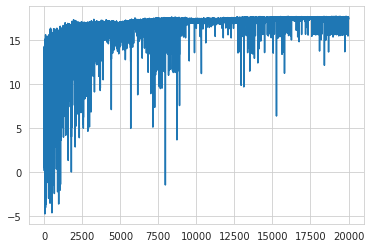

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.lineplot( [i for i in range(len(training_reward_list))],training_reward_list)


In [ ]:
env.reset()

array([0.06549152, 0.02285947, 0.07501461, 0.07223702, 0.        ,
       0.03599195, 0.09490944, 0.04491568, 0.        , 1.        ],
      dtype=float32)

In [ ]:

env.step(np.array(100))


(array([-5.5511151e-17,  0.0000000e+00,  7.5326991e-01,  6.2317610e-01,
         0.0000000e+00,  3.1154540e-01,  3.5784012e-01,  3.1196964e-01,
         3.5714287e-02,  9.4446534e-01], dtype=float32),
 -0.3119696378707886,
 False,
 {})

In [ ]:
scores_window = deque(maxlen=100) 
average_100 = []

In [ ]:
for i in range(len(training_reward_list)):
  scores_window.append(training_reward_list[i])
  average_100.append(np.mean(scores_window))


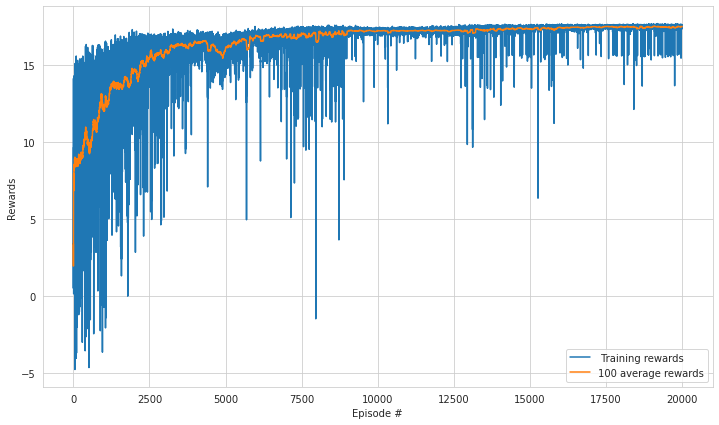

In [ ]:

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(training_reward_list)+1), training_reward_list, label = " Training rewards")
plt.plot(np.arange(1, len(average_100)+1), average_100, label = "100 average rewards")
plt.legend()
plt.ylabel('Rewards')
plt.xlabel('Episode #')
plt.show()